<span style="font-size:200%">Machine Learning</span><br>

<hr style="background: #eee; height: 0.5em">

Muchos problemas de percepción artificial trabajan con datos sensoriales que tienen una enorme variabilidad estadística. Pensemos, por ejemplo, en los innumerables cambios en el array de pixels de la foto de una misma persona al cambiar de posición, de iluminación, la expresión de la cara, etc.. No es factible diseñar un algoritmo o fórmula matemática para el reconocimiento facial de identidad. La forma más práctica de abordar estas situaciones es mediante el ajuste empírico de un modelo genérico de asociación entrada/salida con un conjunto representativo de ejemplos resueltos.

Este proceso se suele descomponer en dos etapas. Primero se transforman los datos crudos en *feature vectors* que un experto humano considera útiles para cada problema concreto. Después se construye automáticamente un clasificador mediante alguna técnica que analiza la distribución estadística de estos vectores y produce una regla de decisión que optimiza un cierto criterio de calidad.

Desde muy temprano en la historia de la computación se propusieron métodos para unir ambas etapas y realizar el proceso completo de aprendizaje de forma automática, pero no había máquinas suficientemente potentes para abordar problemas realistas. Finalmente, a mediados de los años 10 de este siglo la enorme potencia de cálculo de las GPU y las bases de datos masivas recolectadas de internet hicieron posible métodos de aprendizaje muy satisfactorios ("*deep learning*") que clasifican directamente los datos crudos, obteniendo *features* de forma automática.

Este notebook contiene un caso de estudio para ilustrar los aspectos más básicos de machine learning para visión artificial.

Vamos a construir un clasificador de dígitos manuscritos (10 categorías, del cero al nueve). El objetivo es tomar imágenes en vivo con la webcam y clasificar las manchas encontradas. En la sesión práctica conseguiremos algo como lo siguiente:

![digitslive](../images/demos/digitslive.png)

Por ahora no nos preocupamos de los falsos positivos que aparecen fuera del papel. En la parte inferior se muestran las manchas candidatas normalizadas en tamaño. El color amarillo más apagado indica poca confianza en la clasificación.

Para conseguir esto vamos a seguir los siguientes pasos:

- Primero construiremos un clasificador sencillo, eficiente y bastante eficaz. Aunque actualmente hay una tendencia a resolver todos los problemas con la artillería pesada de deep learning, mi recomendación es probar primero una técnica más simple y directa para tener una base sobre la que comparar y valorar las ventajas de métodos más costosos.


- El método que probaremos consiste en hacer primero una reducción de dimensión mediante PCA (componentes principales), de manera que las imágenes de los números se convierten en vectores de 20 propiedades. Este método de reducción de dimensión es uno de los más simples.


- Después construiremos un clasificador gaussiano, que se basa en aproximar la nubes de puntos de las clases con regiones de forma elíptica (como pelotas de rugby en el espacio de propiedades multidimensional). Es un método también muy sencillo que solo necesita los vectores medios y las matrices de covarianza de cada clase, que miden la localización y la dispersión en el espacio.


- Estas operaciones las programaremos con la ayuda del paquete scikit-learn. En realidad es fácil programarlo de cero con numpy pero no nos sobra tiempo y es muy importante conocer este paquete.


- Para entrenar la máquina usaremos la base de datos MNIST, que es el "hello world" de machine learning.


- A continuación programaremos el procedimiento de normalización de la imagen. Tenemos que convertir las manchas negras que encontramos en las imágenes en vivo en el formato muy concreto que espera la máquina de clasificación. Si no hacemos esto bien los resultados serán muy pobres.


- En este punto ya podemos poner en marcha una sencilla aplicación de reconocimiento de números manuscritos como la del pantallazo anterior.


- La máquina que hemos construido tiene una probabilidad de error inferior al 4%, que no está nada mal teniendo en cuenta su gran sencillez. Pero veremos que comete algunos errores que parecen poco justificados. Nos gustaría conseguir un sistema más preciso.


- Para ello, vamos a construir primero una red neuronal multicapa tradicional. Para entrenarla de forma eficiente es necesario tener una GPU nvidia relativamente reciente y el software adecuado. Afortunadamente, el servicio online "colab" de google permite usar máquinas virtuales con GPU que tienen instalados todos los paquetes necesarios y donde podemos trabajar con notebooks jupyter. Y siempre podemos descargarnos las redes ya entrenadas del servidor de la asignatura, pero merece la pena probar el servicio colab, o poner en marcha nuestra propia GPU si tenemos una con las características adecuadas.


- Encontraremos que este tipo de red multicapa consigue más precision que nuestro sencillo clasificador gaussiano pero no es una mejora sustancial que justifique el esfuerzo de cómputo. Para conseguir una mejora significativa utilizaremos una red convolucional. Además de las las capas de proceso tradicionales, este tipo de arquitectura incluye filtros de imagen (las máscaras de convolución que vimos en una clase anterior) cuyos coeficientes se ajustan automáticamente para resolver la tarea. La arquitectura convolucional, con este tipo de filtros adaptables, junto con etapas de reducción de tamaño y otras heurísticas de optimización supone un verdadero salto cualitativo en la visión artificial. En este problema de juguete se consigue una precisión que ningún otro método alternativo puede igualar, pero lo mismo ocurre en muchos otros problemas realistas.


- Para programar los modelos de deep learning usaremos el paquete "keras", que es muy potente y fácil de usar. En el siguiente tema vamos a poner en marcha varias demos de deep learning que necesitarán algunos paquetes y versiones concretos. (Estamos preparando una imagen docker que tenga todo lo necesario.)


Las secciones marcadas con asterisco (<b>*</b>) tratan temas más avanzados o específicos que no hace falta estudiar en este momento para seguir los pasos anteriores. Podéis saltarlos sin ningún problema. Pero, si os interesan estos temas, cuando tengáis tiempo leed al menos el apartado de "Regularización" y "adversarial examples".

Antes de empezar podéis mirar esta breve introducción a [*pattern recogntion*](https://robot.inf.um.es/material/va/via-pr.pdf). 


## scikit-learn

Algunos algoritmos sencillos se podrían programar de cero si tuviéramos un poco más de tiempo. En nuestro caso es preferible practicar con la excelente biblioteca [scikit-learn](http://scikit-learn.org/stable/).

Es muy sencilla de usar. Por ejemplo, para entrenar un árbol de decisión con el clásico problema de clasificación de flores [IRIS](https://en.wikipedia.org/wiki/Iris_flower_data_set), se hace lo siguiente:

In [1]:
from sklearn import datasets

dataset = datasets.load_iris()

In [2]:
# dataset.keys()

In [3]:
# print(dataset['DESCR'])

Entrenamos un [árbol de decisión](https://en.wikipedia.org/wiki/Decision_tree_learning) con una parte de los ejemplos, reservando el resto para evaluar su calidad.

In [4]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split

(train_data  , test_data, 
 train_labels, test_labels) = train_test_split(dataset.data, dataset.target)

model = DecisionTreeClassifier()
model.fit(train_data, train_labels)
print(model)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')


Ya podemos clasificar casos nuevos:

In [5]:
model.predict([ [6 , 3 , 3 , 1.5] ])

array([1])

Un objeto con ese vector de atributos se clasifica dentro de la clase 1, que corresponde a la flor *Iris- Versicolour*.

Finalmente, evaluamos la calidad del modelo obtenido con los ejemplos de test.

In [6]:
from sklearn import metrics

expected = test_labels
predicted = model.predict(test_data)

print(metrics.classification_report(expected, predicted))
print(metrics.confusion_matrix(expected, predicted))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00        16
           1       0.77      0.91      0.83        11
           2       0.89      0.73      0.80        11

   micro avg       0.89      0.89      0.89        38
   macro avg       0.89      0.88      0.88        38
weighted avg       0.90      0.89      0.89        38

[[16  0  0]
 [ 0 10  1]
 [ 0  3  8]]


El resultado depende de la partición aleatoria de los ejemplos, pero normalmente se clasifican casi todos bien. En realidad es un problema de clasificación muy sencillo.

## MNIST dataset

Nuestro objetivo es construir un sistema que reconozca números manuscritos en imágenes tomadas con una cámara. Para ello vamos a aprovechar la conocida base de datos MNIST:

http://yann.lecun.com/exdb/mnist/

Es el *hello world* de *machine learning*.

In [7]:
%matplotlib inline

import matplotlib.pyplot as plt
import numpy             as np
import numpy.linalg      as la

Por comodidad, tenemos la base de datos en un archivo comprimido de numpy, que permite guardar varios arrays. Los recuperamos en un diccionario.

In [8]:
mnist = np.load("../data/mnist.npz")

list(mnist.keys())

['yl', 'yt', 'xl', 'xt']

Tenemos los datos de entrenamiento (`xl`) y de test (`xt`) con las correspondientes etiquetas `yl` e `yt`. Las etiquetas están codificadas con vectores "one-shot" (todo ceros excepto un uno en la posición de cada clase), que convertimos a etiquetas enteras (`cl` y `ct`).

In [9]:
xl,yl,xt,yt = [mnist[d] for d in ['xl', 'yl', 'xt', 'yt']]

cl = np.argmax(yl,axis=1)
ct = np.argmax(yt,axis=1)

print(xl.shape, yl.shape, cl.shape)
print(xt.shape, yt.shape, ct.shape)

(60000, 784) (60000, 10) (60000,)
(10000, 784) (10000, 10) (10000,)


Tenemos objetos de 10 clases (los dígitos del cero al 9). Cada uno es un vector de 784 números entre 0 y 1, que son las filas concatenadas de una imagen pequeñita de 28x28 pixels. Hay 60K ejemplos de entrenamiento y 10K de evaluación.

Veamos qué pinta tiene un ejemplo de entrenamiento cualquiera.

In [10]:
def shdig(v):
    x = np.reshape(v,[28,28])
    plt.imshow(1-x, 'gray', vmin=0, vmax=1, interpolation="nearest");

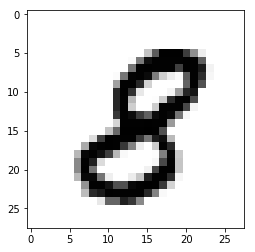

In [11]:
shdig(xl[5])

Definimos una utilidad para ver un conjunto grande de ejemplos.

In [12]:
def muestrario(imgs,n=10):
    N = len(imgs)
    c = N // n
    r = N %  n
    L = imgs + [np.zeros_like(imgs[0]) for k in range(n-r)]
    return np.vstack([ np.hstack([ x for x in L[n*k : n*(k+1)]]) for k in range(c if n*c==N else c+1)])

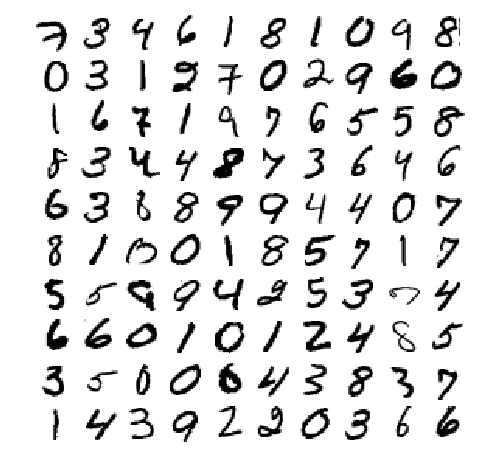

In [13]:
plt.figure(figsize=(8,8))
plt.imshow(-muestrario([x.reshape(28,28) for x in xl[:100]]),'gray');
plt.axis('off');

Algunos son muy raros. Por ejemplo, se supone que lo siguiente es un siete:

[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
7


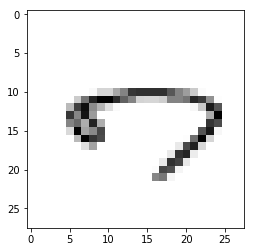

In [14]:
shdig(xl[68])
print(yl[68])
print(cl[68])

## Reducción de dimensión

Aunque la imagen es pequeñita tiene un número de atributos relativamente grande (28x28=784). Mediante el [análisis de componentes principales (PCA)](https://en.wikipedia.org/wiki/Principal_component_analysis) esa dimensión se puede reducir sin demasiada pérdida de información.

In [15]:
from sklearn import decomposition

pca = decomposition.PCA(n_components=20)
pca.fit(xl)
comprime    = pca.transform
descomprime = pca.inverse_transform

tr = comprime(xl)

In [16]:
tr.shape

(60000, 20)

El "8" anterior queda reducido al siguiente vector de 20 atributos:

In [17]:
tr[5]

array([ 1.2996094 , -0.9914152 ,  1.2197835 , -2.730281  ,  1.6226871 ,
        0.22490177, -2.4672916 , -0.519428  , -0.3551128 ,  1.5749642 ,
        2.264567  , -0.9733512 ,  1.0102414 , -1.113513  , -0.2744853 ,
       -0.72794473,  0.19692409, -1.1531596 ,  1.0137979 , -0.05891816],
      dtype=float32)

### Proyección 2D

Vamos a dibujar los digitos en el espacio de las dos componentes principales de la distribución. En azul destacamos los "1", y en gris el resto. El 8 anterior es el punto rojo.

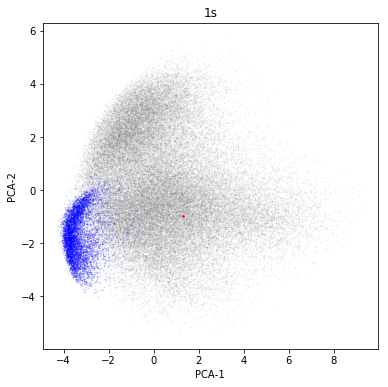

In [18]:
plt.figure(figsize=(6,6))
plt.plot(*tr[cl!=1][:,[0,1]].T,'.',markerSize=1,alpha=0.1,color='gray');
plt.plot(*tr[cl==1][:,[0,1]].T,'.',markerSize=1,alpha=0.2,color='blue');
plt.plot(*tr[5,[0,1]].T,'.',markerSize=3,color='red');
plt.xlabel('PCA-1'); plt.ylabel('PCA-2'); plt.title('1s');

Veamos ahora por ejemplo los "3" y los "8".

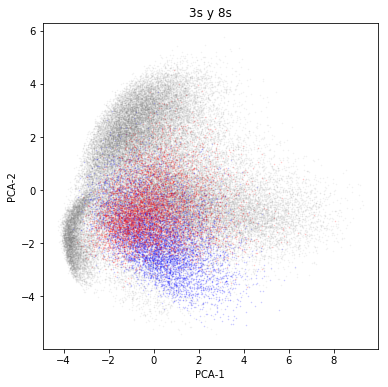

In [19]:
plt.figure(figsize=(6,6))
plt.plot(*tr[(cl!=3) & (cl!=8)][:,[0,1]].T,'.',markerSize=1,alpha=0.1,color='gray');
plt.plot(*tr[cl==3][:,[0,1]].T,'.',markerSize=1,alpha=0.2,color='blue');
plt.plot(*tr[cl==8][:,[0,1]].T,'.',markerSize=1,alpha=0.2,color='red');
plt.xlabel('PCA-1'); plt.ylabel('PCA-2'); plt.title('3s y 8s');

Evidentemente hay mucho solapamiento, pero incluso en esta reducción de dimensión tan brutal (nos quedamos con solo dos parámetros para describir la forma del dígito) se aprecia una cierta estructura.

### Calidad de la reconstrucción *

A partir del vector de dimensión reducida se puede recuperar la imagen original, pero se pierde información. El error de reconstrucción es la varianza de las componentes principales que descartamos.

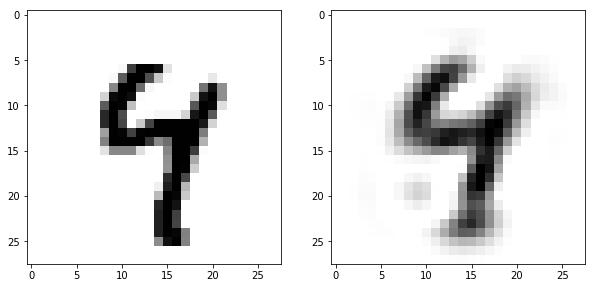

In [20]:
k = 2
plt.figure(figsize=(10,5))
plt.subplot(121)
shdig(xl[k])
plt.subplot(122)
shdig(descomprime(comprime([xl[k]]))[0])

### Modos de variación *

Las direcciones principales de una población a veces pueden interpretarse como variaciones de determinadas características.

Vamos a fijarnos en los treses.

(6131, 784)


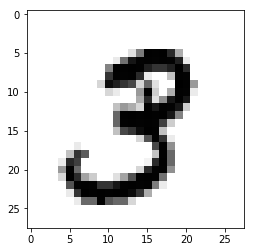

In [21]:
treses = xl[cl==3]
print(treses.shape)
shdig(treses[0])

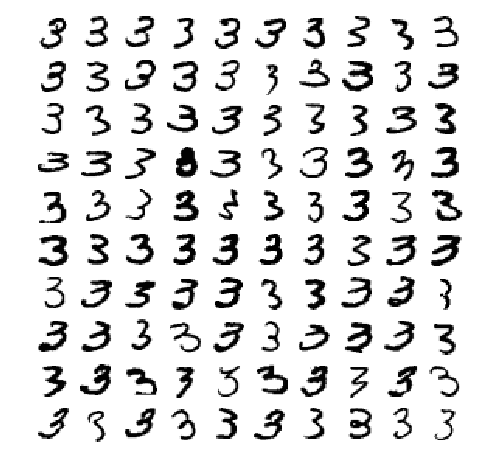

In [22]:
plt.figure(figsize=(8,8))
plt.imshow(-muestrario([x.reshape(28,28) for x in treses[:100]]),'gray');
plt.axis('off');

El valor medio:

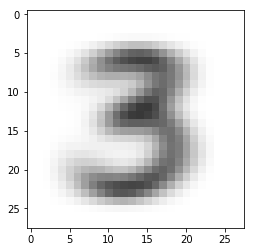

In [23]:
M = np.mean(treses,axis=0)
shdig(M)

La matriz de covarianza describe la variabilidad de la distribución. Es máxima en las direcciones principales, que pueden representarse como objetos del mismo espacio. Son los "eigendigits".

In [24]:
C = np.cov(treses.T)
l,V = np.linalg.eigh(C)
V = np.flipud(V.T)

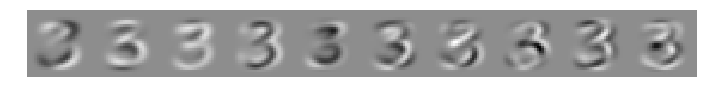

In [25]:
plt.figure(figsize=(12,4))
plt.imshow(-np.bmat([[ (V[k]).reshape(28,28) for k in range(10)]]),'gray'); plt.axis('off');

Cualquier "tres" se puede expresar como el tres medio, al que sumamos o restamos una cierta proporción de estos "modificadores".

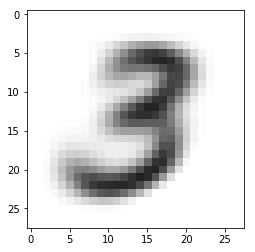

In [26]:
shdig(M + 3*V[0])

Recorriendo un rango de valores vemos que la primera dirección principal de la población de treses está relacionada con la inclinación del número.

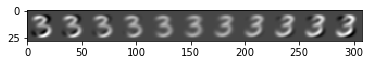

In [27]:
r = np.linspace(-7,7,11)

plt.imshow(np.bmat([[ (M + a*V[0]).reshape(28,28) for a in r]]),'gray');

Lo dibujamos un poco mejor:

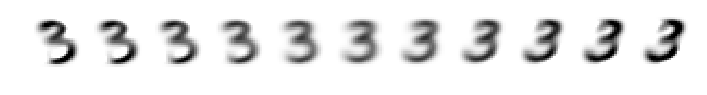

In [28]:
plt.figure(figsize=(12,4))
plt.imshow(1-np.bmat([[ (M + a*V[0]).reshape(28,28) for a in r]]),'gray',vmin=0,vmax=1);
plt.axis('off');

La segunda dirección principal tiene algo que ver con el tamaño de la curva inferior.

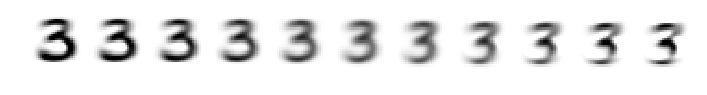

In [29]:
plt.figure(figsize=(12,4))
plt.imshow(1-np.bmat([[ (M + a*V[1]).reshape(28,28) for a in r]]),'gray',vmin=0,vmax=1);
plt.axis('off');

Podemos representar las variaciones en las dos direcciones. El tres medio está en el centro.

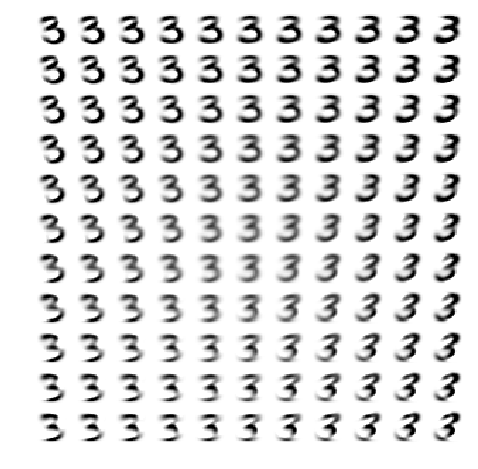

In [30]:
plt.figure(figsize=(8,8))

plt.imshow(1-np.bmat([[ (M + a*V[0] + b*V[1]).reshape(28,28) for a in r] for b in r]),'gray',vmin=0,vmax=1);
plt.axis('off');

## Clasificador Gaussiano

Usamos scikit-learn para construir un clasificador basado clases gaussianas y reducción de dimensión mediante componentes principales (PCA).

In [31]:
from sklearn import random_projection, decomposition, naive_bayes, discriminant_analysis
from sklearn.metrics import confusion_matrix

# una utilidad para calcular la "accuracy" (probabilidad de acierto)
def acc(maq,x,y):
    return 100*(y == maq.predict(x)).sum() / len(y)

Preparamos la operación de reducción de dimensión.

In [32]:
# esta es otra alternativa. Tiene cierto interés porque obtiene propiedades al azar sin analizar la distribución
# transformer = random_projection.GaussianRandomProjection(n_components=60).fit(xl)


transformer = decomposition.PCA(n_components=40).fit(xl)

Y reducimos los datos de entrenamiento y test.

In [33]:
xrl = transformer.transform(xl)
xrt = transformer.transform(xt)

Vamos a probar primero lo que consigue un clasificador "naive Bayes", que trabaja con clases gaussianas pero suponiendo que los atributos son independientes. Tiene más de un 12% de errores.

In [34]:
gnb = naive_bayes.GaussianNB()

In [35]:
maq = gnb.fit(xrl, cl)

In [36]:
acc(maq,xrt,ct)

87.5

El clasificador gaussiano completo tiene menos de 4%.

In [37]:
maq = discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True).fit(xrl,cl)

In [38]:
acc(maq,xrt,ct)

96.24

In [39]:
confusion_matrix(ct, maq.predict(xrt))

array([[ 972,    0,    0,    0,    0,    3,    0,    1,    4,    0],
       [   0, 1099,   11,    4,    1,    1,    1,    0,   18,    0],
       [   3,    0, 1002,    4,    2,    0,    3,    1,   17,    0],
       [   1,    0,    7,  973,    0,    7,    0,    2,   15,    5],
       [   2,    0,    5,    0,  963,    0,    2,    1,    3,    6],
       [   3,    0,    0,   23,    0,  858,    1,    0,    5,    2],
       [   7,    1,    1,    0,    3,   15,  924,    0,    7,    0],
       [   0,    4,   29,    2,    1,    4,    0,  956,   14,   18],
       [   3,    0,    8,   15,    1,    5,    1,    1,  929,   11],
       [   4,    0,   12,    6,   11,    3,    0,    8,   17,  948]])

Podemos clasificar cualquier imagen en el formato 28x28 adecuado:

array([8])

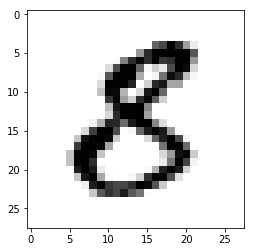

In [40]:
# un ejemplo cualquiera del conjunto de test
dig = xt[1234]

shdig(dig)

maq.predict(transformer.transform(dig.reshape(1,-1)))

(Se hace `reshape` porque la máquina clasifica conjuntos de vectores de características como filas de una matriz.)

Es interesante ver el aspecto que tienen los ejemplos mal clasificados.

In [41]:
fallos = np.where((maq.predict(xrt)!=ct) & (ct==2))[0]
xf = xt[fallos]
len(fallos)

30

Estos son los doses que se clasifican mal:

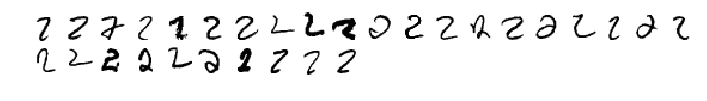

In [42]:
plt.figure(figsize=(12,12))
plt.imshow(-muestrario([x.reshape(28,28) for x in xf],n=20),'gray');
plt.axis('off');

Y estos son todos los fallos:

In [43]:
fallos = np.where((maq.predict(xrt)!=ct))[0]
xf = xt[fallos]
len(fallos)

376

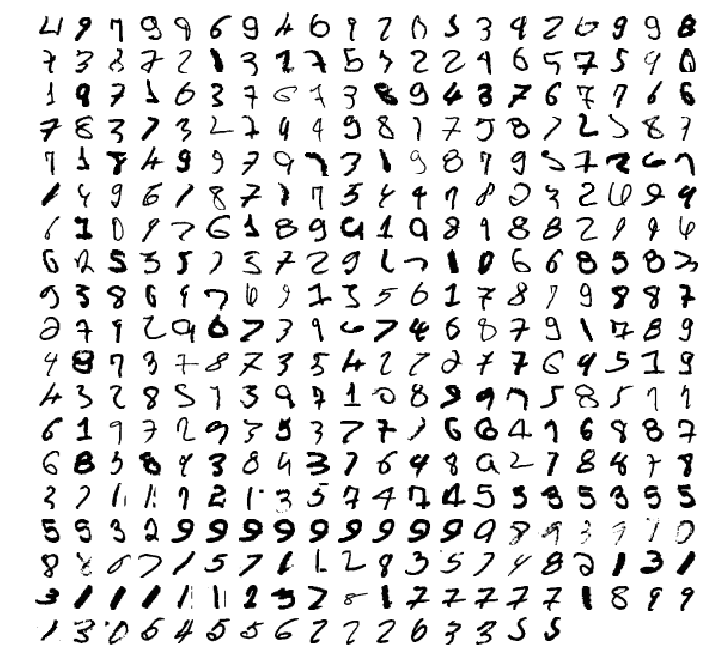

In [44]:
plt.figure(figsize=(12,12))
plt.imshow(-muestrario([x.reshape(28,28) for x in xf],n=20),'gray');
plt.axis('off');

## Imagen real

Para que los clasificadores funcionen bien con imágenes reales es necesario [normalizarlas](http://yann.lecun.com/exdb/mnist/) para que tengan el mismo tamaño y posición que los ejemplos de entrenamiento.

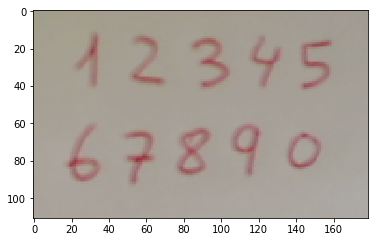

In [45]:
import cv2 as cv

# puedes probar con tus propias fotos
digits = cv.cvtColor(cv.imread('../images/mydigits.png'),cv.COLOR_BGR2RGB);
plt.imshow(digits);

Primero umbralizamos.

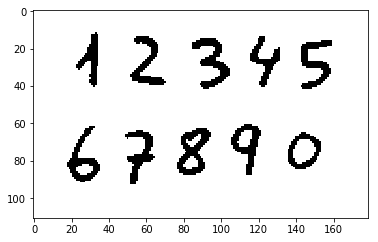

In [46]:
ret, gt = cv.threshold(cv.cvtColor(digits,cv.COLOR_RGB2GRAY),189,255,cv.THRESH_BINARY+cv.THRESH_OTSU)
plt.imshow(gt,'gray');

Las funciones siguientes implementan el proceso de normalización explicado en la página de MNIST.

In [47]:
def center(p):
    r,c = p.shape
    rs = np.outer(range(r),np.ones(c))
    cs = np.outer(np.ones(r),range(c))
    s = np.sum(p)
    my  = np.sum(p*rs) / s
    mx  = np.sum(p*cs) / s
    return mx,my

def boundingBox(c):
    (x1, y1), (x2, y2) = c.min(0), c.max(0)
    return (x1, y1), (x2, y2)

# La figura se escala a un tamaño 20x20
# respetando la proporción de tamaño
# El resultado se mete en una caja 28x28 de
# modo que la media quede en el centro
def adaptsize(x):
    h,w = x.shape
    s = max(h,w)
    h2 = (s-h)//2
    w2 = (s-w)//2
    y = x
    if w2>0:
        z1 = np.zeros([s,w2])
        z2 = np.zeros([s,s-w-w2])
        y  = np.hstack([z1,x,z2])
    if h2>0:
        z1 = np.zeros([h2,s])
        z2 = np.zeros([s-h-h2,s])
        y  = np.vstack([z1,x,z2])
    y = cv.resize(y,(20,20))/255
    mx,my = center(y)
    H = np.array([[1.,0,4-(mx-9.5)],[0,1,4-(my-9.5)]])
    return cv.warpAffine(y,H,(28,28))

Sacamos todos los contornos, los rectángulos que los engloban y adaptamos el tamaño de todas las manchas encontradas.

In [48]:
contours,_ = cv.findContours(255-gt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)[-2:]
regions = [ boundingBox(x.reshape(-1,2)) for x in contours ]

# invertimos para seleccionar la tinta negra como objeto, y tener 0:papel blanco, 1: tinta.
raw = [ 255-gt[y1:y2,x1:x2] for (x1,y1),(x2,y2) in regions if x2-x1 > 10 and y2-y1 > 10]
ok = [ adaptsize(x) for x in raw ]

El resultado es un a lista de imágenes 28x28 del mismo tipo que las que hay en MNIST.

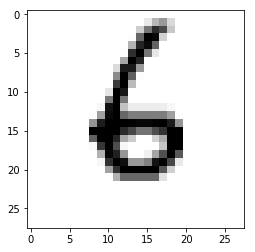

In [49]:
plt.imshow(-ok[3],'gray');

Una vez hecho esto se pueden utilizar con el clasificador:

array([7])

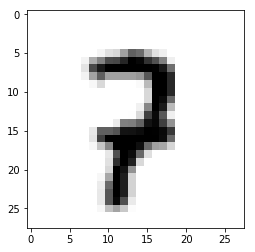

In [50]:
dig = ok[1].flatten()

shdig(dig)

maq.predict(transformer.transform(dig.reshape(1,-1)))

Vamos a clasificar todos los encontrados en la imagen natural:

array([0, 7, 8, 6, 9, 5, 3, 4, 2, 4])

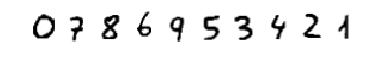

In [51]:
digits = np.array(ok).reshape(-1,28*28)

plt.imshow(-np.hstack([x.reshape(28,28) for x in ok]),'gray'); plt.axis('off');

maq.predict(transformer.transform(digits))

No está mal, pero el "uno" se confunde con un 4 a pesar de que no tiene una forma muy rara. 

Ejercicio: poner en marcha este clasificador con imágenes en vivo de la webcam, como se muestra en el pantallazo inicial.

## Validez del modelo gaussiano *

Si el modelo gaussiano de la distribución de clases es correcto podríamos generar muestras sintéticas realistas.

### Muestras sintéticas *

[0.00316267 0.01687633]
[[ 3.97890649 -3.08595167]
 [-3.08595167  5.07691502]]


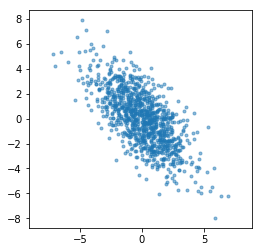

In [59]:
# comprobamos la forma de generar muestras normales multivariables
C = np.array([[4,-3],[-3,5]])
if False:
    kk = np.random.multivariate_normal((0,0),C,1000)
else:
    CC = np.linalg.cholesky(C)  # ojo
    kk = np.random.randn(1000,2) @ CC.T
    
plt.figure(figsize=(4,4))
plt.plot(*kk.T,'.',alpha=0.5);
plt.axis('equal');
print(np.mean(kk,axis=0))
print(np.cov(kk.T))

In [60]:
from sklearn import decomposition

In [61]:
selected = xl[cl==3]

pca = decomposition.PCA(n_components=5)

pca.fit(selected)
#pca.fit(xl)

tr = pca.transform(selected)

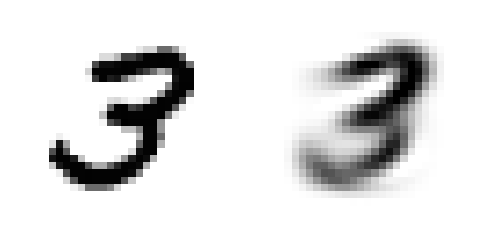

In [62]:
k = 5

plt.figure(figsize=(8,4))
plt.subplot(121)
shdig(selected[k])
plt.axis('off');
plt.subplot(122)
shdig(pca.inverse_transform(tr[[k]])[0])
plt.axis('off');

In [63]:
M = np.mean(tr,axis=0)
C = np.cov(tr.T)

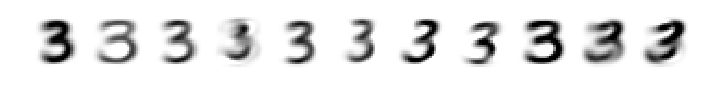

In [64]:
plt.figure(figsize=(12,4))
plt.imshow(1-np.bmat([[ pca.inverse_transform([np.random.multivariate_normal(M,C)])[0].reshape(28,28) for _ in range(11)]]),'gray',vmin=0,vmax=1);
plt.axis('off');

Otra posibilidad es hacer un [QQ plot](https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot) para comparar gráficamente las distribución de distancias de Mahalanobis, que es chi cuadrado.

Caso de prueba con una gaussiana real:

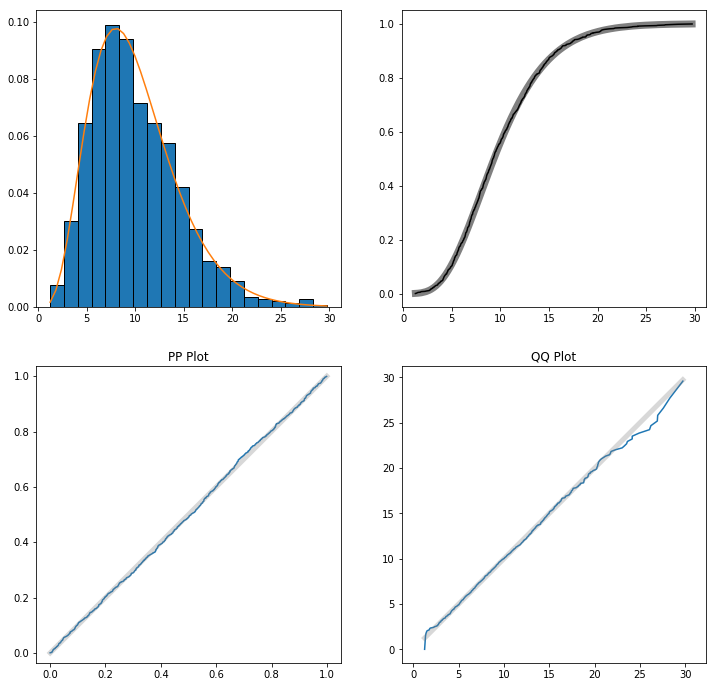

In [65]:
from scipy.stats import chi2

df = 10
data = np.sum(np.random.randn(1000,df)**2,axis=1)

rv = chi2(df)

x = sorted(data)
n = len(x)
y = np.linspace(1/n,1,n)
y = np.arange(n)/n

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.hist(data,bins=20,edgecolor='black',density=True);
X = np.linspace(min(data),max(data),50)
plt.plot(X,rv.pdf(X));

plt.subplot(222)
plt.plot(x, rv.cdf(x), lw=7,color='gray');
plt.plot(x,y,color='black');

plt.subplot(223)
plt.plot(y,rv.cdf(x));
plt.plot([0,1],[0,1],'gray',lw=5,alpha=0.3)
plt.axis('equal'); plt.title('PP Plot')

plt.subplot(224)
plt.plot(x, rv.ppf(y))
mn = np.min(x)
mx = np.max(x)
plt.plot([mn,mx],[mn,mx],'gray',lw=5,alpha=0.3)
plt.axis('equal'); plt.title('QQ Plot');

#print(mn,mx)

Con los dígitos seleccionados:

In [66]:
def distMah2(m,ic,v):
    return (v-m) @ ic @ (v-m)

def dm(m,c):
    ic = np.linalg.inv(c)
    return lambda v: distMah2(m,ic,v)

In [67]:
d = dm(M,C)

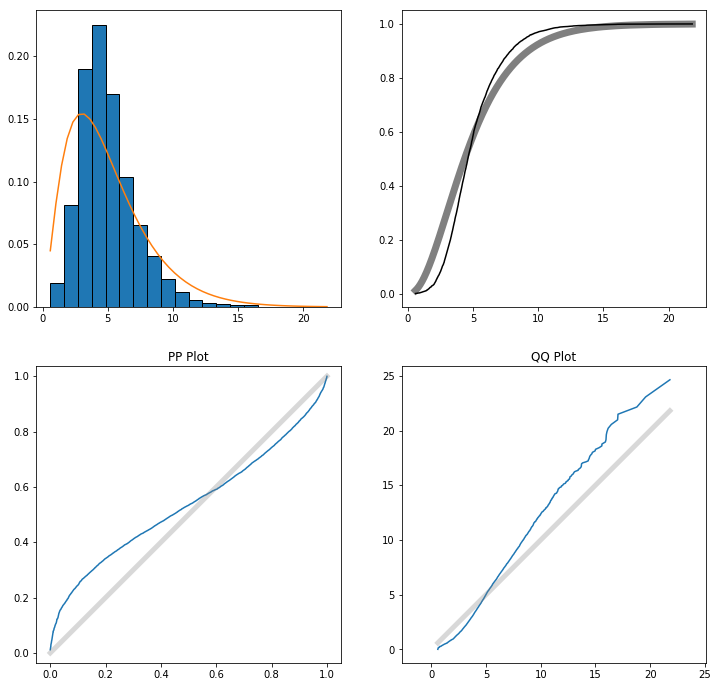

In [68]:
data = [d(x) for x in tr]

df = len(M)

rv = chi2(df)

x = sorted(data)
n = len(x)
y = np.linspace(1/n,1,n)
y = np.arange(n)/n

plt.figure(figsize=(12,12))
plt.subplot(221)
plt.hist(data,bins=20,edgecolor='black',density=True);
X = np.linspace(min(data),max(data),50)
plt.plot(X,rv.pdf(X));

plt.subplot(222)
plt.plot(x, rv.cdf(x), lw=7,color='gray');
plt.plot(x,y,color='black');

plt.subplot(223)
plt.plot(y,rv.cdf(x));
plt.plot([0,1],[0,1],'gray',lw=5,alpha=0.3)
plt.axis('equal'); plt.title('PP Plot')

plt.subplot(224)
plt.plot(x, rv.ppf(y))
mn = np.min(x)
mx = np.max(x)
plt.plot([mn,mx],[mn,mx],'gray',lw=5,alpha=0.3)
plt.axis('equal'); plt.title('QQ Plot');

#print(mn,mx)

No es exactamente normal. A pesar de ello, si las nubes no están muy solapadas el clasificador se comportará bien.

### Objetos extremos *

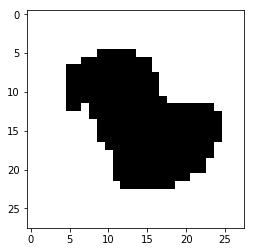

In [69]:
raro=np.argmax(data)
shdig(selected[raro])

In [70]:
raros = sorted(range(len(selected)),key=lambda k:d(tr[k]))

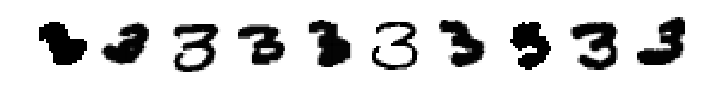

In [71]:
plt.figure(figsize=(12,4))
plt.imshow(1-np.bmat([[ selected[raros[-k]].reshape(28,28) for k in range(1,11)]]),'gray',vmin=0,vmax=1);
plt.axis('off');

## Regularización *

Para conseguir **generalización** es necesario controlar la capacidad de la máquinas de aprendizaje.

Vamos a ilustrar este principio con una máquina lineal. Seleccionamos dos clases y ponemos las salidas deseadas de la máquina a valores +1 y -1:

In [72]:
n = 100
ca = 4
cb = 9

# seleccionamos las posiciones de las clases que nos interesan
sel_l = (cl == ca) | (cl==cb)
sel_t = (ct == ca) | (ct==cb)

# extraemos esas posiciones
# x e y seleccionadas para aprendizaje
# usaré solo los n primeros para aprender
xsl = xl[sel_l][:n]
ysl = cl[sel_l].astype(int)[:n]

# y ponemos correctamente los valores deseados, positivo o negativo
ysl[ysl==ca] =  1
ysl[ysl==cb] = -1

# y lo mismo para el x e y seleccionadas para test (evaluación independiente)
xst = xt[sel_t]
yst = ct[sel_t].astype(int)

yst[yst==ca] =  1
yst[yst==cb] = -1

In [73]:
np.sum(sel_l)

11791

In [74]:
def shdig(v):
    x = np.reshape(v,[28,28])
    plt.imshow(1-x, 'gray', vmin=0, vmax=1, interpolation="nearest");

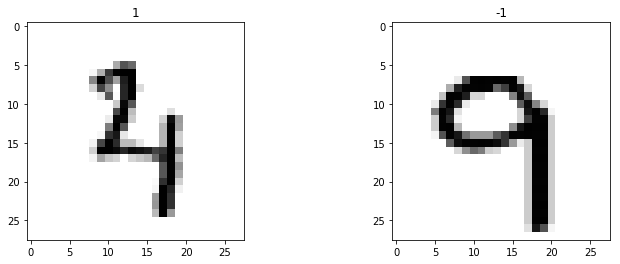

In [75]:
k1,k2 = 55, 56
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
shdig(xsl[k1])
plt.title(ysl[k1])
plt.subplot(1,2,2)
shdig(xsl[k2])
plt.title(ysl[k2]);

In [76]:
xsl.shape

(100, 784)

In [77]:
yst

array([ 1,  1, -1, ...,  1, -1,  1])

conveniente para añadir el término independiente (offset) a una máquina lineal

In [78]:
def homog(x):
    r,c = x.shape
    return np.hstack([x, np.ones([r,1])])

solución de mínimos cuadrados para un sistema lineal

Deseo encontrar $W$ tal que `xsl @ w = ysel`

O sea, resolver $X w= y$

Usarmos `lstsq` del módulo de álgebra lineal `numpy.linalg`, que obtiene la solución de mínimo error cuadrático de un sistema (ver el notebook de [sistemas de ecuaciones](sistecs.ipynb)).

`lstsq` no es lo ideal para mostrar este efecto en el caso no regularizado, porque para sistemas subdeterminados obtiene la solución de mínima norma, y por tanto, también regulariza.

In [79]:
W,_,_,_ = la.lstsq(homog(xsl),ysl,rcond=None)

In [80]:
#W

In [81]:
#homog(xsl) @ W

In [82]:
#np.sign(homog(xsl) @ W) == np.sign(ysl)

contamos los aciertos

In [83]:
np.sum(np.sign(homog(xsl) @ W) == np.sign(ysl)), len(ysl)

(100, 100)

Tiene buena pinta, acierta todos los ejemplos de entrenamiento.

In [84]:
np.sign(homog(xst) @ W) == np.sign(yst)

array([ True,  True,  True, ...,  True,  True,  True])

In [85]:
np.sum(np.sign(homog(xst) @ W) == np.sign(yst)), len(yst)

(1740, 1991)

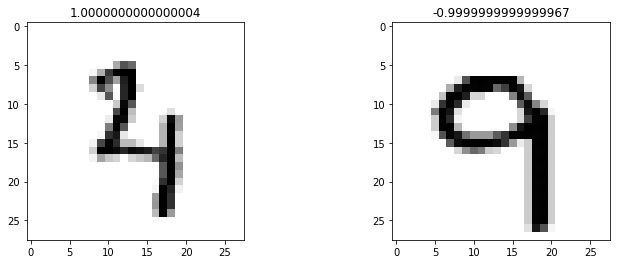

In [86]:
k1,k2 = 55, 56
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
shdig(xsl[k1])
plt.title((homog(xsl) @ W)[k1])
plt.subplot(1,2,2)
shdig(xsl[k2])
plt.title((homog(xsl) @ W)[k2]);

Obtiene exactamente los valores deseados $\pm 1$, ya que tiene más grados de libertad (coeficientes ajustables) que restricciones (ecuaciones, número de ejemplos de entrenamiento). Esto inspira poca confianza en el comportamiento con ejemplos desconocidos:

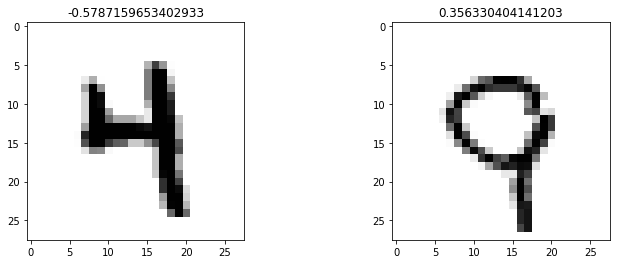

In [87]:
k1,k2 = 70, 55
plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
shdig(xst[k1])
plt.title((homog(xst) @ W)[k1])
plt.subplot(1,2,2)
shdig(xst[k2])
plt.title((homog(xst) @ W)[k2]);

Vamos a construir una solución regularizada, que penaliza con un peso $\lambda$ el tamaño de los coeficientes, para que se reduzca la interpolación de detalles irrelevantes.

La solución regularizada es muy parecida a la de mínimos cuadrados, pero hay que "inflar" la covarianza $X^TX$ con $\lambda$. En lugar de 

$w = (X^T X) ^{-1} X^T y$

(esto es lo que hace internamente lstsq, es la "pseudoinversa" de X, por y)

hacemos

$w = (X^T X + \lambda I) ^{-1} X^T y$

In [88]:
lam = 2E2

D = np.diag(lam*np.ones([784+1]))
D[-1,-1] = 0
# el coeficiente  b no se regulariza,
# porque la posición del hiperplano puede ser cualquiera, no hay que 
# promover que se acerque al origen

In [89]:
#D

In [90]:
xh = homog(xsl)
Wr = la.solve(xh.T @ xh + D, xh.T @ ysl)

In [91]:
np.sum(np.sign(homog(xsl) @ Wr) == np.sign(ysl)), len(ysl)

(98, 100)

In [92]:
np.sum(np.sign(homog(xst) @ Wr) == np.sign(yst)), len(yst)

(1846, 1991)

**Ejercicio**: crea una curva comparando $E_L$ con $E_T$ para valores crecientes de $\lambda$.

In [93]:
Lam = [0.01, 0.1, 1, 5, 10, 50, 100, 200, 500, 1000, 2000, 3000, 5000]

def regu():
    xh = homog(xsl)
    L = []
    T = []
    for l in Lam:
        D = np.diag(l*np.ones([784+1]))
        D[-1,-1] = 0
        Wr = la.solve(xh.T @ xh + D, xh.T @ ysl)
        EL = np.sum(np.sign(homog(xsl) @ Wr) == np.sign(ysl)), len(ysl)
        ET = np.sum(np.sign(homog(xst) @ Wr) == np.sign(yst)), len(yst)
        L.append(EL[0]/EL[1])
        T.append(ET[0]/ET[1])
    return 1-np.array(L), 1-np.array(T)

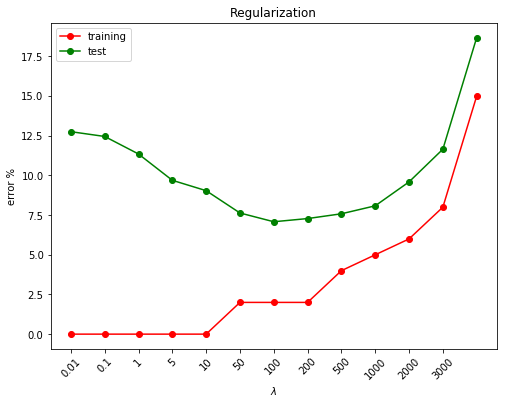

In [94]:
plt.figure(figsize=(8,6))
l,t = regu()
plt.plot(100*l,'o-',label='training',color='red')
plt.plot(100*t,'o-',label='test',color='green')
plt.xticks(np.arange(12), Lam, rotation=45)
plt.legend()
plt.xlabel('$\lambda$'); plt.ylabel('error %')
plt.title('Regularization');

Esta gráfica ilustra el principio teórico fundamental de *machine learning*: la **generalización** está relacionada con la **capacidad** de la máquina. 

Recientemente se ha observado un nuevo fenómeno: **Deep Double Descent** [[blog1](https://www.alignmentforum.org/posts/FRv7ryoqtvSuqBxuT/understanding-deep-double-descent), [blog2](https://openai.com/blog/deep-double-descent/), [paper](https://mltheory.org/deep.pdf)].
Si aumentamos aún más la capacidad de la máquina (típicamente utilizando redes neuronales profundas) el error de test ¡vuelve a disminuir!
(En el gráfico anterior sería movernos hacia la izquierda, el eje está al revés que en estas referencias.)

## *Adversarial examples*  *

Es posible sintetizar instancias aparentemente inocentes pero que confunden al clasificador.

### Gaussian classifier *

El clasificador gaussiano consigue menos de 4% de error.

In [100]:
from sklearn import decomposition, discriminant_analysis

def acc(maq,x,y):
    return 100*(y == maq.predict(x)).sum() / len(y)

In [101]:
transformer = decomposition.PCA(n_components=40).fit(xl)

In [102]:
xrl = transformer.transform(xl)
xrt = transformer.transform(xt)

In [103]:
maq = discriminant_analysis.QuadraticDiscriminantAnalysis(store_covariance=True).fit(xrl,cl)

In [104]:
acc(maq,xrt,ct)

96.25

### Adversarial examples *

Calculamos la dirección en la que hay que mover un objeto v para que se acerque a la clase c.

In [105]:
def mkg(transformer,maquina,c,v):
    d0 = transformer.transform([v])[0] - maquina.means_[c]
    d1 = np.linalg.inv(maquina.covariance_[c]) @ d0
    d2 = transformer.inverse_transform(d1)
    return d2

array([3.71485179e-10, 9.99998559e-01])

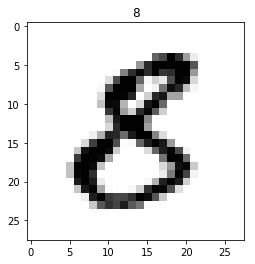

In [106]:
cdesired = 5

k = 1234
v0 = xt[k]
v = v0
corig = ct[k]
shdig(v0); plt.title(corig);
redu = transformer.transform([v])
maq.predict_proba(redu)[0][[cdesired,corig]]

array([0.54755949, 0.45236201])

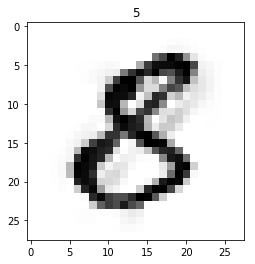

In [107]:
for _ in range(10):
    g = mkg(transformer, maq, corig, v) - mkg(transformer, maq, cdesired, v)
    v = np.clip(v + 0.01*g, 0, 1)
    redu = transformer.transform([v])
    cp = maq.predict(redu)[0]
    if cp != corig: break
    
shdig(v)
plt.title(cp)
maq.predict_proba(redu)[0][[cdesired,corig]]

15.83707


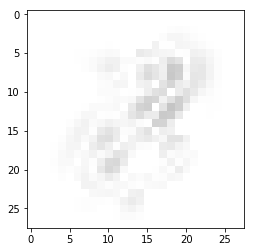

In [108]:
shdig(abs(v-v0))
print(np.sum(abs(v-v0)))

### Random inputs *

0.9579858053216678

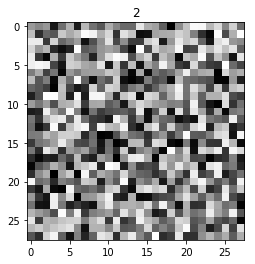

In [15]:
v0 = np.random.rand(28,28).flatten()
shdig(v0)
v = v0
redu = transformer.transform([v])
plt.title(maq.predict(redu)[0]);
maq.predict_proba(redu)[0].max()

0.9992338176090401

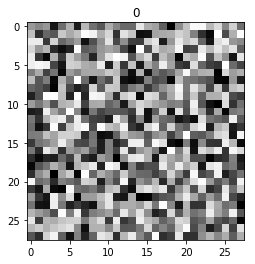

In [16]:
cdesired = 0
for _ in range(3):
    g = - mkg(transformer, maq, cdesired, v)
    v = np.clip(v + 0.01*g, 0, 1)
    redu = transformer.transform([v])
    cp = maq.predict(redu)[0]
    
shdig(v)
plt.title(cp)
maq.predict_proba(redu)[0][cdesired]

In [17]:
maq.predict_proba(redu)[0]

array([9.99233818e-01, 0.00000000e+00, 7.26036111e-04, 4.43242351e-08,
       1.70266218e-34, 3.89210424e-05, 3.29263193e-29, 1.11126225e-53,
       1.18091294e-06, 4.25241712e-31])

10.46400383834251


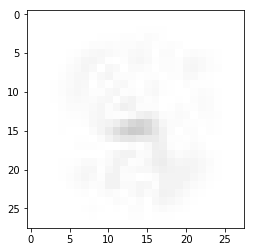

In [18]:
shdig(abs(v-v0))
print(np.sum(abs(v-v0)))

## Otras máquinas de aprendizaje *

Intentamos, sin mucho éxito, mejorar el resultado anterior con otras máquinas de aprendizaje.

### Naive Bayes *

In [38]:
from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB()

maq = gnb.fit(xl, cl)

In [39]:
acc(maq,xt,ct)

55.58

In [40]:
maq.predict(digits)

array([0, 9, 8, 6, 9, 8, 3, 8, 6, 6])

Sin reducción de dimensión (sobre los pixels crudos) el método gaussiano con atributos independientes funciona muy mal. Se puede mejorar un poco con un pequeño truco para implementar un método de clasificación por mínima distancia a la media.

In [41]:
maq.sigma_ = maq.sigma_ * 0 + 1

In [42]:
acc(maq,xt,ct)

82.05

In [43]:
maq.predict(digits)

array([0, 2, 8, 6, 9, 5, 3, 9, 2, 1])

### Support vector machine (SVM) *

In [44]:
from sklearn import svm

classifier = svm.SVC(gamma=0.01, C=0.1)
#classifier = svm.SVC(gamma=0.001)

classifier.kernel

'rbf'

In [45]:
maq = classifier.fit(xl[:5000], cl[:5000])

maq.support_vectors_.shape

(3731, 784)

In [46]:
acc(maq,xt,ct)

90.9

In [47]:
maq.predict(digits)

array([0, 2, 8, 6, 9, 5, 3, 4, 2, 1])

In [39]:
#import pickle
#s = pickle.dumps(maq)

In [40]:
#from sklearn.externals import joblib
#joblib.dump(maq, 'svm.pkl') 

['svm.pkl']

In [41]:
#maq = joblib.load('svm.pkl') 

### Gradient Boosting *

In [24]:
from sklearn import ensemble

In [39]:
clf = ensemble.GradientBoostingClassifier(subsample=0.1, n_estimators=50, max_features=50, min_samples_split=10)

clf.fit(xl, cl)

GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=50, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=10,
              min_weight_fraction_leaf=0.0, n_estimators=50,
              presort='auto', random_state=None, subsample=0.1, verbose=0,
              warm_start=False)

In [40]:
clf.score(xl,cl), clf.score(xt,ct)

(0.9142166666666667, 0.9137)

### Random Forest *

In [52]:
clf = ensemble.RandomForestClassifier(n_estimators=100,n_jobs=-1)

clf.fit(xl, cl)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [53]:
clf.score(xl,cl), clf.score(xt,ct)

(1.0, 0.9696)

No está mal, pero no compensa la sencillez del método PCA+Gaussiano.

## Deep Learning

Finalmente, entrenamos redes neuronales artificiales.

### MLP

In [ ]:
import numpy             as np

mnist = np.load("../data/mnist.npz")

xl,yl,xt,yt = [mnist[d] for d in ['xl', 'yl', 'xt', 'yt']]

print(xl.shape, yl.shape)
print(xt.shape, yt.shape)

En primer lugar probamos un sencillo perceptrón multicapa. Mediante el paquete keras la definición de la red es muy simple:

    pip install keras tensorflow


In [13]:
from keras.models import Sequential
from keras.layers import Dense, Softmax, Flatten
from keras.utils import plot_model

model = Sequential()
model.add(Flatten( input_shape=(28,28,1)))
model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

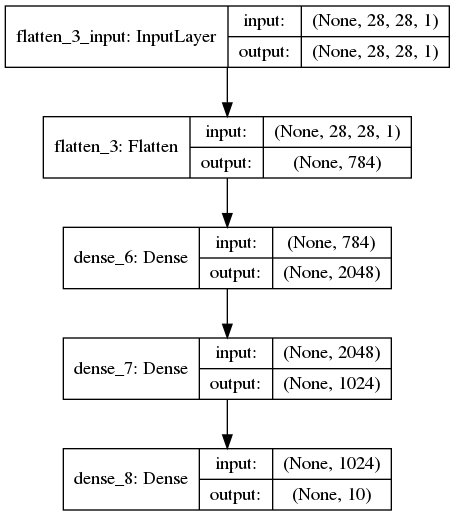

In [14]:
plot_model(model, show_shapes=True)

In [83]:
# puedes ejecutar lo siguiente varias veces hasta conseguir una calidad aceptable.
model.fit(xl.reshape(-1,28,28,1), yl, epochs=100, batch_size=500)
model.evaluate(xt.reshape(-1,28,28,1),yt, batch_size=500)

10000/10000 [==============================] - 0s 13us/step


[0.08080655024386943, 0.9746000170707703]

En 200 "epochs" se consigue una tasa de aciertos de 97.5%. Sigue sin merecer la pena.

### CNN

La solución satisfactoria se consigue con una [red convolucional](https://github.com/fchollet/deep-learning-with-python-notebooks).

In [16]:
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPool2D, Dropout, Softmax, Flatten
from keras.utils import plot_model

model = Sequential()
model.add(Conv2D(input_shape=(28,28,1), filters=32, kernel_size=(5,5), strides=1,
                 padding='same', use_bias=True, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Conv2D(filters=64, kernel_size=(5,5), strides=1,
                 padding='same', use_bias=True, activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(1024,activation='relu'))
model.add(Dropout(rate=0.5))
model.add(Dense(10, activation='softmax'))

model.compile(loss='categorical_crossentropy',
              optimizer='sgd',
              metrics=['accuracy'])

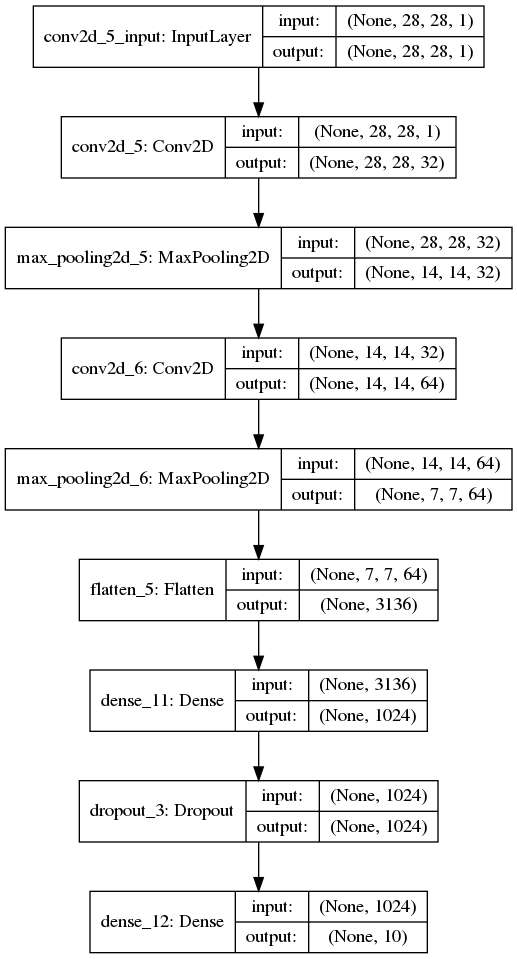

In [17]:
plot_model(model, show_shapes=True)

Si no quieres lanzar el proceso de aprendizaje (muy lento sin GPU) puedes descargarte los pesos con wget como se indica, ponerlos en la carpeta data y ejercutar la celda siguiente.

In [106]:
if False:
    model.fit(xl.reshape(-1,28,28,1), yl, epochs=50, batch_size=500)
    #model.save('digits.keras')
else:
    #wget https://robot.inf.um.es/material/va/digits.keras
    model.load_weights('../data/digits.keras')
    
model.evaluate(xt.reshape(-1,28,28,1),yt, batch_size=500)

10000/10000 [==============================] - 0s 41us/step


[0.027869708283105865, 0.9902999997138977]

Esta máquina clasifica correctamente todos los dígitos de la imagen natural.

array([0, 7, 8, 6, 9, 5, 3, 4, 2, 1])

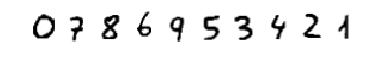

In [107]:
plt.imshow(-np.hstack([x.reshape(28,28) for x in ok]),'gray'); plt.axis('off');

model.predict_classes(np.array(ok).reshape(-1,28,28,1))

La operación de clasificación es muy rápida también en CPU, por lo que se puede usar esta máquina para clasificar dígitos en vivo con la webcam en cualquier ordenador.